In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive1.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

# Color

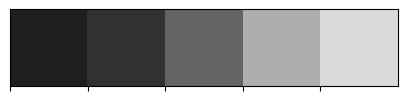

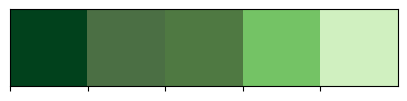

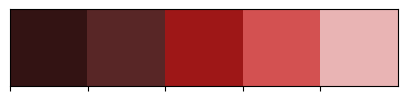

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [ ]:
labels = ['glioma','meningioma','notumor','pituitary']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [ ]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 857.05it/s]


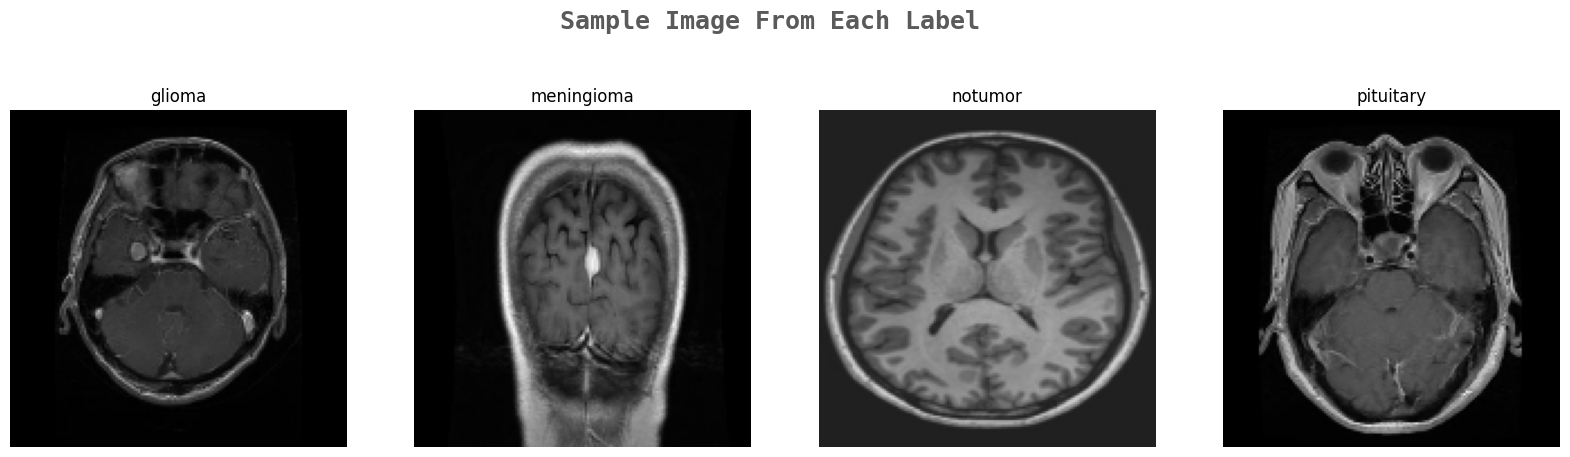

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train.shape

(7023, 150, 150, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
image_size = [150,150] # choose image size
# import the base model
# efnB7 = tf.keras.applications.efficientnet.EfficientNetB7(input_shape= image_size+[3],weights='imagenet',include_top=False)
efnB7=ResNet50(input_shape= image_size+[3],weights='imagenet',include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = efnB7.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(4,activation='softmax')(x)
model = Model(inputs = efnB7.input,outputs=preds)

In [ ]:
# freeze base layers for training
for layer in efnB7.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 27,262,340 (104.00 MB)

 Trainable params: 3,674,628 (14.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

We finally compile our model.

In [ ]:
# initial optimizer
optimizer_initial = 'SGD'
# compile the model
model.compile(optimizer=optimizer_initial,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
# checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =25, verbose=1, batch_size=8,
                   callbacks=[tensorboard,reduce_lr])

Epoch 1/25
711/711 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.7661 - loss: 0.6304 - val_accuracy: 0.8592 - val_loss: 0.3427 - learning_rate: 0.0100
Epoch 2/25
711/711 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9077 - loss: 0.2521 - val_accuracy: 0.9320 - val_loss: 0.1971 - learning_rate: 0.0100
Epoch 3/25
711/711 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9377 - loss: 0.1727 - val_accuracy: 0.9462 - val_loss: 0.1597 - learning_rate: 0.0100
Epoch 4/25
711/711 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9378 - loss: 0.1518 - val_accuracy: 0.9288 - val_loss: 0.2033 - learning_rate: 0.0100
Epoch 5/25
709/711 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9594 - loss: 0.1070
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
711/711 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.9594 - loss: 0.1070 - val_accuracy: 0.8877 - val_loss: 0.3236 - learning_rate: 0.0100
Epoch 6/25
711/711 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9808 - los

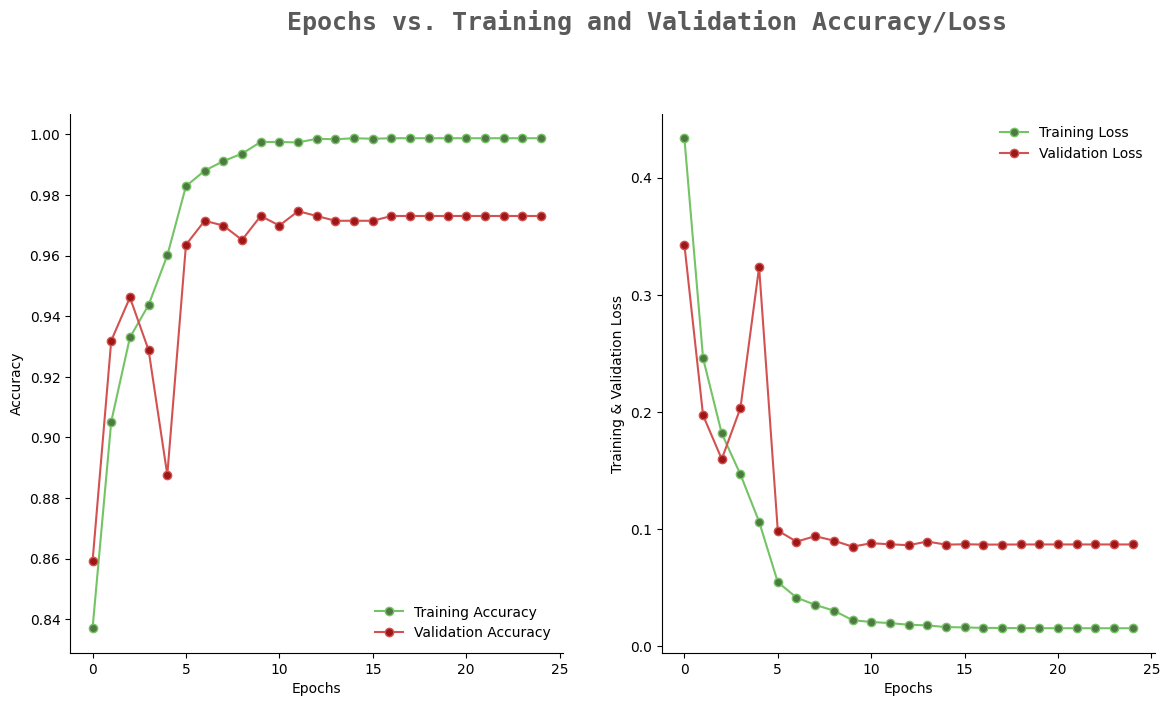

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(25)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       170
           1       0.93      0.93      0.93       175
           2       0.99      1.00      0.99       202
           3       0.99      0.98      0.98       156

    accuracy                           0.96       703
   macro avg       0.96      0.96      0.96       703
weighted avg       0.96      0.96      0.96       703



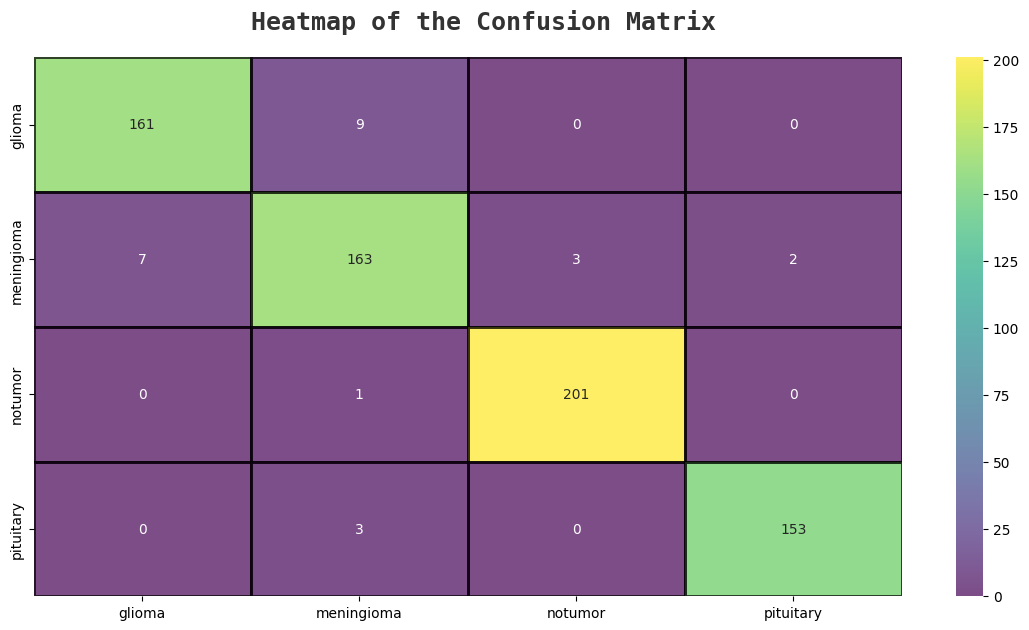

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming pred contains your predicted labels and y_test_new contains the true labels

# Your code for confusion matrix plot
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
cm = confusion_matrix(y_test_new, pred)
sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap='viridis', alpha=0.7, linewidths=2, linecolor='black', fmt='d')  # Use fmt='d' to display integers
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color='black', y=0.92, x=0.28, alpha=0.8)
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


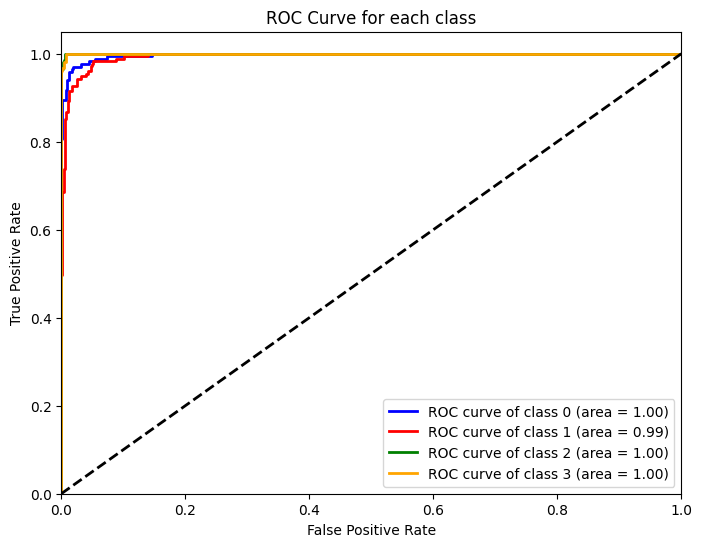

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_bin = label_binarize(y_test_new, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]
pred_proba = model.predict(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        p='Meningioma Tumor'
    elif p==2:
        print('The model predicts that there is no tumor')
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

This is where you can upload the image by clicking on the **Upload** button:

In [ ]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [ ]:
# Print classification report
report = classification_report(y_test_new,pred)
print(report)

# Extract accuracy
accuracy = float(report.splitlines()[-5].split()[1])
print(f"Accuracy: {accuracy:.4f}")


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       170
           1       0.93      0.93      0.93       175
           2       0.99      1.00      0.99       202
           3       0.99      0.98      0.98       156

    accuracy                           0.96       703
   macro avg       0.96      0.96      0.96       703
weighted avg       0.96      0.96      0.96       703

Accuracy: 0.9900


In [ ]:
# Specify the path in your Google Drive where you want to save the model
model_save_path = '/content/drive/My Drive/final-resnet-new-08-08.h5'

# Save the model
model.save(model_save_path)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9644


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0
